In [ ]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.path import Path
from scipy.spatial.distance import cdist
sys.path.append(os.path.abspath('..'))
import lib_gs as lib

In [ ]:
path = '../Donnees/'

In [ ]:
## Mesures de "vent en rafale" du réseau de stations sol
obs_mf =np.loadtxt(f"{path}obs_wind_mf.txt")
E_mf = obs_mf[:,0:1]/1e3 # km
N_mf = obs_mf[:,1:2]/1e3 # km
v_mf = obs_mf[:,2:3]

## Sorties du champ "vent en rafale" de la réanalyse ERA5
obs_era5 = np.loadtxt(f"{path}mod_wind_era5.txt")
E_era5 = obs_era5[:, 0:1] / 1e3  # km
N_era5 = obs_era5[:, 1:2] / 1e3  # km
v_era5 = obs_era5[:, 2:3]

# Contour de la France métropolitaine
FR_contour =np.loadtxt(f"{path}FR_contour.txt")
E = FR_contour[:,0:1]/1e3
N = FR_contour[:,1:2]/1e3

## Fonction de validation Croisée

In [ ]:
c,a = lib.fit_var_ana(E_mf, N_mf, v_mf,hmax=160,nmax = 500,model="cub")

In [ ]:
def cross_validation(x_obs, y_obs, z_obs, num_points=50):

    n = len(x_obs)

    # Sélection aléatoire des points de test
    idx_test = np.random.choice(n, size=num_points, replace=False)
    x_test = x_obs[idx_test]
    y_test = y_obs[idx_test]
    z_test = z_obs[idx_test]

    # Points d'entraînement (tous sauf les points de test)
    x_train = np.delete(x_obs, idx_test, axis=0)
    y_train = np.delete(y_obs, idx_test, axis=0)
    z_train = np.delete(z_obs, idx_test, axis=0)

    errors_lin = []
    errors_krg = []
    errors_spline = []
    errors_inv_dist = []

    for i in range(num_points):
        # Interpolation linéaire
        z_lin = lib.interp_lin(x_train, y_train, z_train, x_test[i:i+1], y_test[i:i+1])
        errors_lin.append(z_lin[0, 0] - z_test[i])

        # Interpolation par Krigeage
        z_krg = lib.interp_krg(x_obs, y_obs, z_obs, x_test[i:i+1], y_test[i:i+1], c=c, a=a, kind_var="cub", r_maw_var=160, card_var=500)
        errors_krg.append(z_krg[0, 0] - z_test[i])


        # Interpolation par spline
        # z_spline = lib.interp_spline(x_train, y_train, z_train, x_test[i:i+1], y_test[i:i+1], p=1)
        # print(z_spline)
        # errors_spline.append(z_spline[0, 0] - z_test[i])

        # Interpolation par inverse distance
        # z_inv_dist = lib.inter_inv_dist(x_obs, y_obs, z_obs, x_test[i:i+1], y_test[i:i+1], p=2, nb_pts=-1)
        # print(z_inv_dist[0, 0], z_test[i])
        # print(z_inv_dist[0, 0] - z_test[i])
        # errors_inv_dist.append(z_inv_dist[0, 0] - z_test[i])

    stats_lin = compute_stats(errors_lin)
    stats_krg = compute_stats(errors_krg)
    # stats_spline = compute_stats(errors_spline)
    # stats_inv_dist = compute_stats(errors_inv_dist)

    return stats_lin, stats_krg
def compute_stats(errors):
    errors = np.array(errors)
    stats = {
            'erreur moyenne,': np.nanmean(errors),
        'écart-type de l\'erreur': np.nanstd(errors),
        'erreur moyenne quadratique': np.sqrt(np.nanmean(errors**2))
    }
    return stats

## Tests

In [ ]:
# stats = cross_validation(E_mf, N_mf, v_mf, num_points=20)
print("Statistiques pour l'interpolation linéaire :")
# print(stats[0], "\n")

print("Statistiques pour l'interpolation par krigeage", "\n")
# print(stats[1])

# print("Statistiques pour l'interpolation par spline :")
# print(stats)

# print("Statistiques pour l'interpolation par inverse des distances :")
# print(stats, "\n")

## Carte de la vitesse du vent

In [ ]:
# Calcul des limites et du nombre de points
x_min, x_max = np.floor(np.min(E_mf)), np.ceil(np.max(E_mf))
y_min, y_max = np.floor(np.min(N_mf)), np.ceil(np.max(N_mf))

resolution = 30  # Pas de 30 km
num_x = int((x_max - x_min) / resolution) + 1  # Nombre de points en x
num_y = int((y_max - y_min) / resolution) + 1  # Nombre de points en y
# Création de la grille
x_grd, y_grd = np.meshgrid(
    np.linspace(x_min, x_max, num_x),
    np.linspace(y_min, y_max, num_y)
)

In [ ]:
z_grd = lib.interp_lin(E_mf, N_mf, v_mf, x_grd, y_grd)

# Création du contour de la France sous forme de polygone
france_contour = Path(np.column_stack((E, N)))

# Liste des points interpolés à tester
points_interpoles = np.column_stack((x_grd.ravel(), y_grd.ravel()))

mask = france_contour.contains_points(points_interpoles, radius=15)

mask = mask.reshape(x_grd.shape)  # Remise en forme du masque

# Appliquer le masque à la grille
x_grd = x_grd[mask]
y_grd = y_grd[mask]
z_grd = z_grd[mask]

In [ ]:
fig = plt.figure(figsize=(12,12))
# chargement de la carte de couleur et conversion au format matplotlib
NCL = col.ListedColormap(np.loadtxt(f"{path}ncl.rgb")/255)
# tracé des vitesses ERA5, sous forme de cercles de taille 20, avec un contour gris de taille 0.2
lib.plot_patch(E_era5,N_era5,v_era5,fig = fig, minmax = [20, 190], cmap = NCL, s=20,
               xlabel='E (km)',ylabel='N (km)', zlabel = 'v (km/h)',lw=0.2, ec='0.5')
# tracé des vitesses observées, sous forme de carrés de taille 42, avec un contour noir de taille 0.5, sans colorbar
lib.plot_patch(E_mf,N_mf,v_mf,fig=fig,minmax = [20,190],marker='s',s=42,cmap=NCL,lw=0.5, ec='k',cb=False)
# tracé des contours
plt.legend(['ERA5','MF'])
plt.grid()

plt.figure(figsize=(12, 10))
plt.scatter(x_grd, y_grd, c=z_grd, cmap=NCL, s=10)
plt.colorbar(label='Vitesse du vent (km/h)')
plt.plot(E, N, 'k', linewidth=1)
plt.xlabel('E (km)')
plt.ylabel('N (km)')
plt.title('Vitesses de vent en rafale interpolées (interpolation linéaire)')
plt.grid()
plt.show()

## Évaluation des sorties de la réanalyse ERA5

In [20]:
# Calcul des distances entre chaque point ERA5 et chaque point d'observation
distances = cdist(np.column_stack((E_era5, N_era5)), np.column_stack((E_mf, N_mf)), metric='euclidean')
selected_pairs = []
for i in range(distances.shape[0]):
    for j in range(distances.shape[1]):
        if distances[i, j] < 30:
            selected_pairs.append((i,j))

era5_indices, obs_indices = zip(*selected_pairs)
E_era5_selected = E_era5[list(era5_indices)]
N_era5_selected = N_era5[list(era5_indices)]
v_era5_selected = v_era5[list(era5_indices)]
v_obs_selected = v_mf[list(obs_indices)]

# Calcul des erreurs
errors = v_era5_selected - v_obs_selected

# Statistiques d'erreur
error_mean = np.mean(errors)
error_std = np.std(errors)
rmse = np.sqrt(np.mean(errors**2))

print("Erreur moyenne :", error_mean)
print("Écart-type de l'erreur :", error_std)
print("Erreur quadratique moyenne (RMSE) :", rmse)

Erreur moyenne : 6.396607032695867
Écart-type de l'erreur : 18.179375806455116
Erreur quadratique moyenne (RMSE) : 19.27190406376754


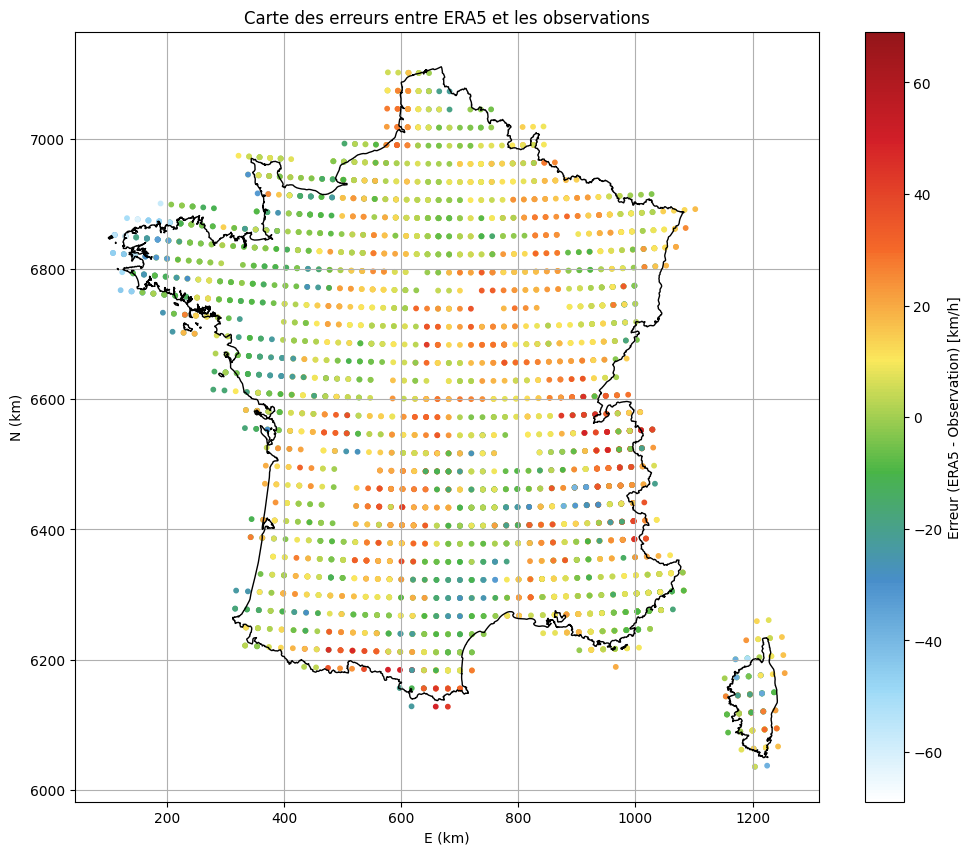

In [23]:
plt.figure(figsize=(12, 10))
sc = plt.scatter(E_era5_selected, N_era5_selected, c=errors, cmap=NCL, s=10)
plt.colorbar(sc, label='Erreur (ERA5 - Observation) [km/h]')
plt.plot(E, N, 'k', linewidth=1)  # Contour de la France
plt.xlabel('E (km)')
plt.ylabel('N (km)')
plt.title('Carte des erreurs entre ERA5 et les observations')
plt.grid()
plt.show()